In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
import numpy as np
from math import log, exp, sqrt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# from estimate import posterior_decoding, sample_paths
from bmws.sim import sim_admix
from bmws.plotting import plot_summary, compute_rmse, bias_variance
from itertools import combinations_with_replacement, product

rng = np.random.default_rng()

N_SIMULATIONS = 10
N_EM_ITERATIONS = 3
set_matplotlib_formats("svg")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


/var/folders/45/24r_y0v140zdn6qzsr8rzm10hm8l1b/T/ipykernel_94849/1919966932.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

## Simple model
Strong selection in one population, neutrality in others

In [4]:
T = 100  # number of time points
K = 3  # number of populations
d = 10  # sample every d generations
N = 100  # number of samples then

mdl = {
    "s": [[0.1] * (T - 1)] + [[0.0] * (T - 1)] * (K - 1),
    "h": [[0.5] * (T - 1)] * K,
    "f0": [0.1] * K,
}
mdl = {k: np.transpose(v) for k, v in mdl.items()}
rng = np.random.default_rng(1)
thetas = rng.dirichlet(np.ones(K), [T, N])  # admixture proportions
samples = np.zeros([T, N])
samples[::d] = 1

<IPython.core.display.Javascript object>

# One run

In [5]:
%%time
res = sim_admix(
    mdl,
    seed=1,
    thetas=thetas,
    samples=samples,
    M=100,
    estimate_kwargs={"lam": 1e4, "gamma": 0.0},
)

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[2.23326794 1.0001     2.80685941]
 [5.69485778 8.96786538 9.55146815]]
INFO:bmws.sim:s: [[ 0.06723021 -0.00712146 -0.00667882]
 [ 0.06721597 -0.00710037 -0.00671349]
 [ 0.0671883  -0.00705809 -0.00678271]
 [ 0.06714707 -0.00699487 -0.00688635]
 [ 0.06709432 -0.00691036 -0.00702423]
 [ 0.06702945 -0.00680512 -0.0071963 ]
 [ 0.0669551  -0.00667856 -0.00740234]
 [ 0.06686939 -0.00653149 -0.00764237]
 [ 0.06677507 -0.00636315 -0.00791613]
 [ 0.06666895 -0.00617451 -0.00822369]
 [ 0.06655223 -0.00596557 -0.00856786]
 [ 0.06649841 -0.00571546 -0.00890614]
 [ 0.06650939 -0.005424   -0.00924129]
 [ 0.06658091 -0.00509258 -0.00957347]
 [ 0.06671787 -0.00471984 -0.00990226]
 [ 0.06691634 -0.00430746 -0.01022786]
 [ 0.06718246 -0.00385388 -0.01054977]
 [ 0.06751252 -0.00336095 -0.01086824]
 [ 0.06791336 -0.00282695 -0.01118265]
 [ 0.06838083 -0.00225385 -0.01149322]
 [ 0.06892047 -0.00164061 -0.01179968]
 [ 0.06943622 -0.00102699 -0.01210547]
 [ 0.

INFO:bmws.sim:EM iteration 2
INFO:bmws.sim:ab: [[2.18508298 1.0001     2.74566051]
 [5.72862788 8.98099043 9.57599808]]
INFO:bmws.sim:s: [[ 6.66021319e-02 -6.75026563e-03 -7.31233268e-03]
 [ 6.65880235e-02 -6.72971533e-03 -7.34680083e-03]
 [ 6.65664005e-02 -6.68648330e-03 -7.41532515e-03]
 [ 6.65251364e-02 -6.62489066e-03 -7.51834276e-03]
 [ 6.64836608e-02 -6.53855371e-03 -7.65482875e-03]
 [ 6.64174537e-02 -6.43603192e-03 -7.82580350e-03]
 [ 6.63581195e-02 -6.30679536e-03 -8.02960949e-03]
 [ 6.62688855e-02 -6.16350536e-03 -8.26791656e-03]
 [ 6.61927141e-02 -5.99163935e-03 -8.53839281e-03]
 [ 6.60811085e-02 -5.80780641e-03 -8.84345700e-03]
 [ 6.59881146e-02 -5.59369359e-03 -9.18002941e-03]
 [ 6.59324673e-02 -5.34875413e-03 -9.51382443e-03]
 [ 6.59785207e-02 -5.05119576e-03 -9.84094589e-03]
 [ 6.60578805e-02 -4.72470795e-03 -1.01656595e-02]
 [ 6.62441356e-02 -4.34435125e-03 -1.04831320e-02]
 [ 6.64606517e-02 -3.93682722e-03 -1.07986686e-02]
 [ 6.67890577e-02 -3.47439713e-03 -1.11064038e-

CPU times: user 25min 28s, sys: 11.8 s, total: 25min 39s
Wall time: 26min 15s


<IPython.core.display.Javascript object>

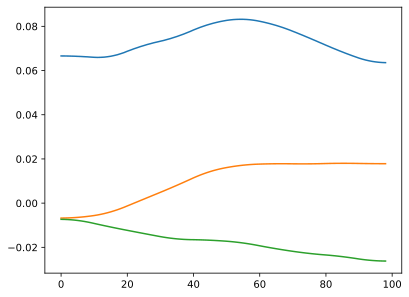

<IPython.core.display.Javascript object>

In [6]:
for s in res["s_hat"].T:
    plt.plot(s)

In [29]:
thetas.shape

(100, 100, 3)

<IPython.core.display.Javascript object>

In [7]:
%%time
res = []
for i in range(10):
    res.append(
        sim_admix(
        mdl,
        seed=i,
        thetas=thetas,
        samples=samples,
        M=100,
        estimate_kwargs={"lam": 1e4, "gamma": 0.0},
    ))

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[ 1.80929494  1.63499937  2.07578507]
 [10.3296806   8.55380879  8.27756099]]
INFO:bmws.sim:s: [[ 0.07696721 -0.0317244  -0.02852233]
 [ 0.0770162  -0.03165633 -0.0284834 ]
 [ 0.07711067 -0.03152111 -0.0284063 ]
 [ 0.0772567  -0.03131692 -0.02828964]
 [ 0.07744419 -0.03104654 -0.02813558]
 [ 0.07768493 -0.03070643 -0.02794142]
 [ 0.07796318 -0.03030105 -0.02771063]
 [ 0.0782958  -0.02982536 -0.02743933]
 [ 0.07866294 -0.02928531 -0.02713215]
 [ 0.07908576 -0.02867458 -0.02678425]
 [ 0.07954185 -0.02800016 -0.02640104]
 [ 0.07999535 -0.02728548 -0.02599346]
 [ 0.08042329 -0.02653833 -0.02556752]
 [ 0.08084928 -0.02575097 -0.02511743]
 [ 0.08125138 -0.0249317  -0.02464948]
 [ 0.08165122 -0.02407258 -0.02415787]
 [ 0.08202844 -0.02318202 -0.02364883]
 [ 0.08240202 -0.02225205 -0.02311669]
 [ 0.08275377 -0.02129106 -0.02256754]
 [ 0.08309995 -0.02029122 -0.02199594]
 [ 0.08342481 -0.01926079 -0.02140772]
 [ 0.08376546 -0.01822539 -0.0208133 ]

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[2.23326794 1.0001     2.80685941]
 [5.69485778 8.96786538 9.55146815]]
INFO:bmws.sim:s: [[ 0.06723021 -0.00712146 -0.00667882]
 [ 0.06721597 -0.00710037 -0.00671349]
 [ 0.0671883  -0.00705809 -0.00678271]
 [ 0.06714707 -0.00699487 -0.00688635]
 [ 0.06709432 -0.00691036 -0.00702423]
 [ 0.06702945 -0.00680512 -0.0071963 ]
 [ 0.0669551  -0.00667856 -0.00740234]
 [ 0.06686939 -0.00653149 -0.00764237]
 [ 0.06677507 -0.00636315 -0.00791613]
 [ 0.06666895 -0.00617451 -0.00822369]
 [ 0.06655223 -0.00596557 -0.00856786]
 [ 0.06649841 -0.00571546 -0.00890614]
 [ 0.06650939 -0.005424   -0.00924129]
 [ 0.06658091 -0.00509258 -0.00957347]
 [ 0.06671787 -0.00471984 -0.00990226]
 [ 0.06691634 -0.00430746 -0.01022786]
 [ 0.06718246 -0.00385388 -0.01054977]
 [ 0.06751252 -0.00336095 -0.01086824]
 [ 0.06791336 -0.00282695 -0.01118265]
 [ 0.06838083 -0.00225385 -0.01149322]
 [ 0.06892047 -0.00164061 -0.01179968]
 [ 0.06943622 -0.00102699 -0.01210547]
 [ 0.

INFO:bmws.sim:EM iteration 2
INFO:bmws.sim:ab: [[2.18508298 1.0001     2.74566051]
 [5.72862788 8.98099043 9.57599808]]
INFO:bmws.sim:s: [[ 6.66021319e-02 -6.75026563e-03 -7.31233268e-03]
 [ 6.65880235e-02 -6.72971533e-03 -7.34680083e-03]
 [ 6.65664005e-02 -6.68648330e-03 -7.41532515e-03]
 [ 6.65251364e-02 -6.62489066e-03 -7.51834276e-03]
 [ 6.64836608e-02 -6.53855371e-03 -7.65482875e-03]
 [ 6.64174537e-02 -6.43603192e-03 -7.82580350e-03]
 [ 6.63581195e-02 -6.30679536e-03 -8.02960949e-03]
 [ 6.62688855e-02 -6.16350536e-03 -8.26791656e-03]
 [ 6.61927141e-02 -5.99163935e-03 -8.53839281e-03]
 [ 6.60811085e-02 -5.80780641e-03 -8.84345700e-03]
 [ 6.59881146e-02 -5.59369359e-03 -9.18002941e-03]
 [ 6.59324673e-02 -5.34875413e-03 -9.51382443e-03]
 [ 6.59785207e-02 -5.05119576e-03 -9.84094589e-03]
 [ 6.60578805e-02 -4.72470795e-03 -1.01656595e-02]
 [ 6.62441356e-02 -4.34435125e-03 -1.04831320e-02]
 [ 6.64606517e-02 -3.93682722e-03 -1.07986686e-02]
 [ 6.67890577e-02 -3.47439713e-03 -1.11064038e-

INFO:bmws.sim:EM iteration 1
INFO:bmws.sim:ab: [[ 4.10568138  1.0001      4.29159803]
 [18.08719526 31.5610471  26.83417117]]
INFO:bmws.sim:s: [[ 6.16399474e-02 -3.99932144e-02 -1.94849914e-02]
 [ 6.16877938e-02 -3.99813816e-02 -1.94612633e-02]
 [ 6.18044167e-02 -3.99275700e-02 -1.94646208e-02]
 [ 6.19438151e-02 -3.98868101e-02 -1.94085679e-02]
 [ 6.21758184e-02 -3.97906286e-02 -1.93940832e-02]
 [ 6.24269055e-02 -3.97050078e-02 -1.93217794e-02]
 [ 6.27324883e-02 -3.95861250e-02 -1.92877665e-02]
 [ 6.31497917e-02 -3.94380197e-02 -1.91888580e-02]
 [ 6.34879076e-02 -3.93076589e-02 -1.91487062e-02]
 [ 6.40729667e-02 -3.90995223e-02 -1.90227608e-02]
 [ 6.44983474e-02 -3.89404360e-02 -1.89557475e-02]
 [ 6.51351423e-02 -3.87232900e-02 -1.88062743e-02]
 [ 6.57450945e-02 -3.85378507e-02 -1.85859110e-02]
 [ 6.63285399e-02 -3.83623847e-02 -1.84082379e-02]
 [ 6.71475565e-02 -3.81383557e-02 -1.80364530e-02]
 [ 6.77387174e-02 -3.79927039e-02 -1.77864259e-02]
 [ 6.86355659e-02 -3.77672527e-02 -1.7343

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[1.0001     1.66601941 1.0001    ]
 [1.90838089 2.82068443 5.29748494]]
INFO:bmws.sim:s: [[ 0.0570203  -0.031744    0.00927382]
 [ 0.05720141 -0.03173648  0.00926446]
 [ 0.05755535 -0.03172099  0.00924611]
 [ 0.05801377 -0.03169122  0.00922643]
 [ 0.0585615  -0.03164637  0.009206  ]
 [ 0.05913411 -0.03158104  0.00919116]
 [ 0.05967852 -0.03149001  0.00918801]
 [ 0.06019814 -0.031375    0.00919385]
 [ 0.06059021 -0.03122512  0.0092221 ]
 [ 0.06092021 -0.0310494   0.00926127]
 [ 0.06129494 -0.03085972  0.00929531]
 [ 0.06156459 -0.03066919  0.00934641]
 [ 0.06184125 -0.03049035  0.00939789]
 [ 0.06220883 -0.03033456  0.00943441]
 [ 0.06257766 -0.03019204  0.00946843]
 [ 0.06297313 -0.0300672   0.00949333]
 [ 0.06337099 -0.02995648  0.00951259]
 [ 0.06371051 -0.02985588  0.00953113]
 [ 0.06402665 -0.02976738  0.00954406]
 [ 0.06428247 -0.02968731  0.00955904]
 [ 0.06448022 -0.02961407  0.00958034]
 [ 0.06474611 -0.0295568   0.00960225]
 [ 0.

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[1.0001     2.01475369 1.0001    ]
 [5.01460161 4.33090038 6.3889068 ]]
INFO:bmws.sim:s: [[ 0.09806659 -0.0154905  -0.04277113]
 [ 0.09809939 -0.01551257 -0.0427496 ]
 [ 0.09816979 -0.01555593 -0.04270535]
 [ 0.09826849 -0.01562206 -0.0426407 ]
 [ 0.09840979 -0.01570856 -0.0425521 ]
 [ 0.09857545 -0.01581841 -0.04244413]
 [ 0.09878876 -0.01594757 -0.04231095]
 [ 0.09902313 -0.01610051 -0.04215932]
 [ 0.09930985 -0.01627155 -0.04198124]
 [ 0.09961464 -0.01646666 -0.04178547]
 [ 0.09997548 -0.01667851 -0.04156207]
 [ 0.10032467 -0.01687898 -0.04133247]
 [ 0.10070643 -0.01705914 -0.0410851 ]
 [ 0.10107248 -0.01722802 -0.0408322 ]
 [ 0.10147301 -0.01737505 -0.0405607 ]
 [ 0.10185444 -0.01751081 -0.04028413]
 [ 0.10227197 -0.01762309 -0.03998823]
 [ 0.1026686  -0.01772399 -0.0396875 ]
 [ 0.1031032  -0.01779972 -0.03936676]
 [ 0.10351684 -0.01786385 -0.03904126]
 [ 0.10397042 -0.01790108 -0.03869515]
 [ 0.10438542 -0.01790403 -0.03836284]
 [ 0.

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[1.0001     1.4040443  1.88399402]
 [6.2215097  5.62460099 5.75888836]]
INFO:bmws.sim:s: [[ 0.06817974 -0.02349837 -0.02715288]
 [ 0.06818095 -0.02351131 -0.02714724]
 [ 0.06818042 -0.0235377  -0.02713675]
 [ 0.06818386 -0.02357645 -0.02711992]
 [ 0.06818248 -0.02362914 -0.02709905]
 [ 0.06818752 -0.02369361 -0.02707118]
 [ 0.06818462 -0.02377251 -0.02704009]
 [ 0.06819045 -0.02386263 -0.02700136]
 [ 0.06818499 -0.02396765 -0.02696023]
 [ 0.06819064 -0.02408332 -0.02691081]
 [ 0.0681819  -0.02421438 -0.0268599 ]
 [ 0.0682126  -0.02433384 -0.02677252]
 [ 0.06825229 -0.0244474  -0.0266568 ]
 [ 0.06833304 -0.02454893 -0.02650427]
 [ 0.06842006 -0.02464495 -0.02632413]
 [ 0.06854922 -0.02472849 -0.02610679]
 [ 0.06868186 -0.02480689 -0.02586258]
 [ 0.06885779 -0.02487239 -0.02558087]
 [ 0.06903451 -0.02493307 -0.02527298]
 [ 0.06925574 -0.02498045 -0.02492729]
 [ 0.06947566 -0.02502334 -0.02455617]
 [ 0.06982307 -0.02505193 -0.02415248]
 [ 0.

INFO:bmws.sim:EM iteration 2
INFO:bmws.sim:ab: [[1.0001     1.46689522 1.89434702]
 [6.25088627 5.6541913  5.78833482]]
INFO:bmws.sim:s: [[ 0.0649494  -0.02678133 -0.03472882]
 [ 0.06495557 -0.02678679 -0.03471298]
 [ 0.06497412 -0.02679663 -0.03467983]
 [ 0.06498984 -0.02681303 -0.0346325 ]
 [ 0.0650217  -0.0268328  -0.03456655]
 [ 0.06504044 -0.02686034 -0.03448818]
 [ 0.06507861 -0.02689036 -0.03439   ]
 [ 0.06509463 -0.02692946 -0.03428127]
 [ 0.06513515 -0.02697024 -0.03415165]
 [ 0.06514725 -0.02702152 -0.03401344]
 [ 0.06519111 -0.02707374 -0.03385335]
 [ 0.06523266 -0.02711816 -0.03366404]
 [ 0.06534298 -0.02714322 -0.03342939]
 [ 0.06544653 -0.02716192 -0.03316756]
 [ 0.06562255 -0.02716079 -0.03285975]
 [ 0.0657846  -0.02715477 -0.03252684]
 [ 0.06601922 -0.02712855 -0.03214748]
 [ 0.06623091 -0.02709887 -0.03174507]
 [ 0.06651369 -0.02704872 -0.03129591]
 [ 0.06676549 -0.02699656 -0.03082576]
 [ 0.06708798 -0.02692372 -0.03030874]
 [ 0.06746067 -0.02685129 -0.0297799 ]
 [ 0.

INFO:bmws.sim:EM iteration 2
INFO:bmws.sim:ab: [[ 1.51270013  3.41246592  1.00212703]
 [ 6.49058543 10.89794684  9.55226011]]
INFO:bmws.sim:s: [[ 8.52902714e-02 -5.13044921e-03 -3.28201007e-03]
 [ 8.53435175e-02 -5.11482764e-03 -3.27042515e-03]
 [ 8.52516012e-02 -5.13225156e-03 -3.28150228e-03]
 [ 8.53172662e-02 -5.10978402e-03 -3.26257598e-03]
 [ 8.52772350e-02 -5.10847582e-03 -3.26059208e-03]
 [ 8.52317896e-02 -5.10913948e-03 -3.25571304e-03]
 [ 8.52938041e-02 -5.08044910e-03 -3.23197390e-03]
 [ 8.51950003e-02 -5.08794179e-03 -3.23347277e-03]
 [ 8.52396532e-02 -5.06446532e-03 -3.20826251e-03]
 [ 8.52302853e-02 -5.04670817e-03 -3.19284329e-03]
 [ 8.51785632e-02 -5.04432564e-03 -3.18191831e-03]
 [ 8.52974454e-02 -5.02592462e-03 -3.13692924e-03]
 [ 8.53152148e-02 -5.05310860e-03 -3.10409757e-03]
 [ 8.54741394e-02 -5.08170426e-03 -3.03945131e-03]
 [ 8.56811770e-02 -5.11818646e-03 -2.96526793e-03]
 [ 8.58450510e-02 -5.19459512e-03 -2.89023077e-03]
 [ 8.62079656e-02 -5.25742341e-03 -2.7792

INFO:bmws.sim:EM iteration 1
INFO:bmws.sim:ab: [[2.41863242 1.0001     1.48775667]
 [5.47508672 7.83173198 5.28618246]]
INFO:bmws.sim:s: [[ 0.047012    0.00915126 -0.07050916]
 [ 0.04705308  0.00914521 -0.07048697]
 [ 0.04713682  0.00913331 -0.07044236]
 [ 0.04726005  0.00911506 -0.07037581]
 [ 0.04742752  0.00909116 -0.07028662]
 [ 0.04763288  0.00906061 -0.07017571]
 [ 0.04788396  0.00902457 -0.07004194]
 [ 0.04817152  0.00898159 -0.06988666]
 [ 0.04850614  0.00893326 -0.0697083 ]
 [ 0.04887626  0.00887771 -0.06950863]
 [ 0.04929478  0.00881693 -0.06928567]
 [ 0.04979698  0.00876309 -0.06905457]
 [ 0.0503982   0.00871854 -0.06881309]
 [ 0.05108163  0.00868067 -0.0685638 ]
 [ 0.05186523  0.0086522  -0.0683041 ]
 [ 0.05272931  0.00863019 -0.06803689]
 [ 0.05369386  0.00861763 -0.06775929]
 [ 0.05473722  0.00861132 -0.06747447]
 [ 0.05588078  0.00861453 -0.06717928]
 [ 0.05710182  0.00862385 -0.06687714]
 [ 0.05842274  0.00864277 -0.06656467]
 [ 0.05973818  0.00866744 -0.06623298]
 [ 0.

INFO:bmws.sim:EM iteration 1
INFO:bmws.sim:ab: [[ 1.0001      2.4801086   1.0001    ]
 [15.95599189 10.35554568 10.10351339]]
INFO:bmws.sim:s: [[ 0.08065719 -0.00407468 -0.01534652]
 [ 0.08063441 -0.00407772 -0.01530224]
 [ 0.0805871  -0.0040844  -0.01521467]
 [ 0.08052275 -0.00409354 -0.01508183]
 [ 0.08043571 -0.00410694 -0.01490672]
 [ 0.08034    -0.00412229 -0.01468544]
 [ 0.08022473 -0.00414257 -0.01442292]
 [ 0.08010836 -0.00416442 -0.01411346]
 [ 0.07997394 -0.00419196 -0.01376382]
 [ 0.07984362 -0.00422086 -0.01336669]
 [ 0.07969339 -0.0042563  -0.01293047]
 [ 0.07958561 -0.00429756 -0.01245696]
 [ 0.07949219 -0.00435072 -0.01195604]
 [ 0.07944368 -0.00440971 -0.0114177 ]
 [ 0.07941091 -0.00448145 -0.01085301]
 [ 0.07942881 -0.00455911 -0.01025086]
 [ 0.07946599 -0.00465032 -0.00962329]
 [ 0.07956042 -0.00474766 -0.0089584 ]
 [ 0.07967776 -0.00485936 -0.00826892]
 [ 0.07985694 -0.00497755 -0.00754242]
 [ 0.08005979 -0.00511089 -0.00679209]
 [ 0.08029051 -0.0052421  -0.00605458]

INFO:bmws.sim:EM iteration 0
INFO:bmws.sim:ab: [[ 1.27175021  1.0001      3.34340666]
 [ 9.23411831 11.412664    6.73208059]]
INFO:bmws.sim:s: [[ 0.08349833 -0.03760687 -0.0362804 ]
 [ 0.08359542 -0.03755972 -0.03624132]
 [ 0.0837273  -0.03747311 -0.03617053]
 [ 0.08400552 -0.03733198 -0.0360535 ]
 [ 0.08425372 -0.03715872 -0.03591189]
 [ 0.08468507 -0.03692456 -0.03571757]
 [ 0.08503106 -0.0366646  -0.03550515]
 [ 0.08559001 -0.03633896 -0.03523468]
 [ 0.08601553 -0.03599238 -0.0349516 ]
 [ 0.08667779 -0.03557737 -0.03460662]
 [ 0.08717427 -0.03514437 -0.03425314]
 [ 0.08794648 -0.03468388 -0.03385737]
 [ 0.08855237 -0.03424776 -0.03347732]
 [ 0.08943926 -0.03378583 -0.03305478]
 [ 0.09014474 -0.03334716 -0.03264876]
 [ 0.0911218  -0.0328864  -0.03220193]
 [ 0.09191221 -0.0324461  -0.03177075]
 [ 0.09296051 -0.03198908 -0.03130223]
 [ 0.09382381 -0.03154857 -0.03084703]
 [ 0.09492084 -0.03109791 -0.03035956]
 [ 0.09584608 -0.03065916 -0.02988192]
 [ 0.09692739 -0.03018958 -0.02939259]

AttributeError: 'dict' object has no attribute 'result'

<IPython.core.display.Javascript object>

In [7]:
for r in res:
    plt.plot(r["s_hat"][:, 0], color="tab:blue", alpha=0.1)
    plt.plot(r["s_hat"][:, 1], color="tab:orange", alpha=0.1)
    plt.plot(r["s_hat"][:, 2], color="tab:green", alpha=0.1)

plt.hlines(0.1, 0, 100, color="tab:blue")

plt.hlines(0.0, 0, 100, color="tab:green")
plt.hlines(0.001, 0, 100, color="tab:orange")


TypeError: string indices must be integers

<IPython.core.display.Javascript object>

## Performance if we incorrectly assume that Ne is constant 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 9))

axs[0][0].axis("off")
optimal_lambda = [5, 4, 3]

for i in range(1, 3):
    axs[i][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

with ThreadPoolExecutor() as pool:
    for i in range(3):
        for j in range(1, 3):
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[i],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[i],
                    Ne=Ne_mdls[j],
                    Ne_fit=[10000] * len(s_mdls[i]["s"]),
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
            plot_summary(axs[j][i + 1], x, y, s_mdls[i]["s"])

## See how RMSE changes as sample size and frequency change

In [ ]:
ns = [1, 10, 100]
ks = [5, 10, 20]
size_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
optimal_lambda = [5, 4, 3]

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")


with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        futs = [
            (
                nn,
                kk,
                seed,
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[j],
                    Ne=Ne_mdls[i],
                    n=nn,
                    k=kk,
                    em_iterations=N_EM_ITERATIONS,
                ),
            )
            for nn, kk, seed in product(ns, ks, range(N_SIMULATIONS))
        ]
        for nn, kk, seed, f in futs:
            this_res = f.result()
            rmse = compute_rmse(this_res["s_hat"], s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "iter": seed,
                    "sampling": str(nn) + "-" + str(kk),
                    "rmse": rmse,
                }
            )

        size_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        plot_res.boxplot(ax=axs[i + 1][j + 1], by="sampling", column=["rmse"])

fig.suptitle(None)
size_res = pd.DataFrame(size_res)

## Smoothing parameter

In [ ]:
log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
lam_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

lam_res = []
with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** lam,
                    Ne=Ne_mdls[i],
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )

        lam_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
lam_res = pd.DataFrame(lam_res)

## Simulations using the sampling distribution of the ancient European samples

In [ ]:
samples = pd.read_csv("allbrit.meta", sep="\t")
samples["GenBP"] = samples.DateBP // 29  # assume 29 years per-generation
counts = samples.GenBP.value_counts().sort_index()
sizes, times = counts.values, np.array(counts.index)

T = times[-1]
s2_mdls = [
    {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / (T - 1)) for x in range(T)],
        "h": [0.5] * T,
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 6)[:T], "h": [0.5] * T, "f0": 0.5},
]
gr = exp(log(100) / T)
Ne_mdl2 = [round(10000 * gr ** (10 * int(x / 10))) for x in range(T)]  # exp growth

In [ ]:
fig, axs = plt.subplots(
    ncols=3, nrows=2, figsize=(12, 6))

optimal_lambda = [5, 4, 2]


with ThreadPoolExecutor() as pool:
    for j in range(3):
        futs = [pool.submit(
            sim_and_fit,
            s2_mdls[j], seed=12345 + seed, lam=10**optimal_lambda[j], Ne=Ne_mdl2, k=times, n=sizes)
                for seed in range(N_SIMULATIONS)
               ]
        res = [f.result() for f in futs]    
        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
        plot_summary(axs[0][j], x, y, s2_mdls[j]["s"])

    log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]

    for j in range(3):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [pool.submit(
                sim_and_fit,
                s2_mdls[j], seed=12345 + seed, lam=10 ** lam, Ne=10000, k=times, n=sizes,em_iterations=N_EM_ITERATIONS
            )
                    for seed in range(N_SIMULATIONS)
                   ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s2_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": "Exp2",
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )


    plot_res = pd.DataFrame(plot_res)
    axs[1][j].tick_params(labelsize=6)
    axs[1][j].xaxis.label.set_visible(False)
    axs[1][j].title.set_visible(False)
    axs[1][j].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
    axs[1][j].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
    axs[1][j].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
